# Sports Complex

In [127]:
import pandas as pd
import ipywidgets as widgets
from datetime import datetime

In [128]:
trainings_1 = pd.read_csv(
    'files/sports_complex/training_details_1.csv',
    parse_dates=['date'],
    date_format='%d/%m/%Y',
)

trainings_2 = pd.read_csv(
    'files/sports_complex/training_details_2.csv',
    parse_dates=['date'],
    date_format='%d/%m/%Y',
)

trainings = pd.concat([trainings_1, trainings_2])

visitors = pd.read_csv('files/sports_complex/visitors.csv')
training_types = pd.read_csv('files/sports_complex/training_types.csv')

trainings = trainings.merge(visitors).merge(training_types)

trainings

,visitor_id,training_type_id,date,visitor_surname,visitor_balance,training_type_title,training_type_price
0,1,5,2015-01-01,Smith,100,Training 5,500
1,1,1,2023-01-01,Smith,100,Training 1,100
2,1,1,2023-01-01,Smith,100,Training 1,100
3,1,1,2023-01-01,Smith,100,Training 1,100
4,2,1,2015-01-03,Johnson,200,Training 1,100
5,2,1,2023-01-01,Johnson,200,Training 1,100
6,2,1,2023-01-01,Johnson,200,Training 1,100
7,3,1,2023-01-01,Williams,300,Training 1,100
8,3,1,2023-01-01,Williams,300,Training 1,100
9,4,1,2023-01-01,Jones,400,Training 1,100


In [129]:
trainings_per_type = trainings[['training_type_id', 'training_type_title']]
trainings_per_type.insert(loc=2, column='number_of_trainings', value=0)
trainings_per_type = trainings_per_type.groupby(['training_type_id', 'training_type_title']).count()

trainings_per_type

,,number_of_trainings
training_type_id,training_type_title,
1,Training 1,11
2,Training 2,2
3,Training 3,1
4,Training 4,2
5,Training 5,1


<Axes: ylabel='number_of_trainings'>

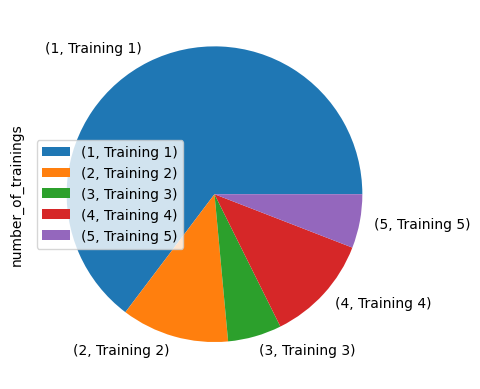

In [130]:
trainings_per_type.plot(kind='pie', y='number_of_trainings')

In [131]:
start_date_picker = widgets.DatePicker(description='Start date:', value=datetime.strptime('01/01/2020', '%d/%m/%Y'))
end_date_picker = widgets.DatePicker(description='End date:', value=datetime.strptime('01/01/2025', '%d/%m/%Y'))


def get_spent_amount(start_date=None, end_date=None):
    try:
        if start_date and end_date and start_date > end_date:
            return 'Please, provide correct data'
    except Exception:
        return 'Please, provide correct data'

    visitors = {}

    trainings_in_range = trainings[
        (pd.to_datetime(start_date) < trainings.date) &
        (pd.to_datetime(end_date) > trainings.date)
        ] if start_date and end_date else trainings

    for training in trainings_in_range.itertuples():
        visitor_id = training.visitor_id
        training_date = training.date

        same_day_trainings = [_training for _training in trainings_in_range.itertuples() if
                              visitor_id == _training.visitor_id and training_date == _training.date]
        has_discount = len(same_day_trainings) > 1

        if not visitors.get(visitor_id):
            visitors[visitor_id] = {
                'visitor_id': training.visitor_id,
                'visitor_surname': training.visitor_surname,
                'visitor_spent_amount': float(1),
                'visitor_balance': training.visitor_balance,
            }

        training_price = training.training_type_price * (0.6 if has_discount else 1)

        visitors[visitor_id]['visitor_spent_amount'] += training_price
        visitors[visitor_id]['visitor_balance'] -= training_price

    return pd.DataFrame.from_dict(visitors).transpose()


widgets.interact(get_spent_amount, start_date=start_date_picker, end_date=end_date_picker)

interactive(children=(DatePicker(value=datetime.datetime(2020, 1, 1, 0, 0), description='Start date:', step=1)…

<function __main__.get_spent_amount(start_date=None, end_date=None)>

<Axes: ylabel='visitor_spent_amount'>

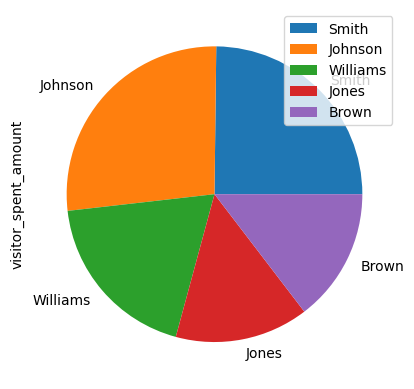

In [132]:
get_spent_amount()[['visitor_surname', 'visitor_spent_amount']].set_index('visitor_surname').plot(kind='pie',
                                                                                                  y='visitor_spent_amount')

In [133]:
visitor_picker = widgets.Dropdown(options=visitors.visitor_surname, description="Surname: ")


def get_visitors_stats(visitor_surname):
    visitor_training_types = {}
    visitor_trainings = trainings[trainings.visitor_surname == visitor_surname]

    for training in visitor_trainings.itertuples():
        if not visitor_training_types.get(training.training_type_title):
            visitor_training_types[training.training_type_id] = {
                'training_type_title': training.training_type_title,
                'training_type_spent_amount': 0
            }

        same_day_trainings = [_training for _training in visitor_trainings.itertuples() if
                              training.visitor_id == _training.visitor_id and training.date == _training.date]
        has_discount = len(same_day_trainings) > 1

        training_price = training.training_type_price * (0.6 if has_discount else 1)
        visitor_training_types[training.training_type_id]['training_type_spent_amount'] += training_price

    return pd.DataFrame.from_dict(visitor_training_types).transpose().sort_values(by='training_type_title')


widgets.interact(get_visitors_stats, visitor_surname=visitor_picker)

interactive(children=(Dropdown(description='Surname: ', options=('Smith', 'Johnson', 'Williams', 'Jones', 'Bro…

<function __main__.get_visitors_stats(visitor_surname)>

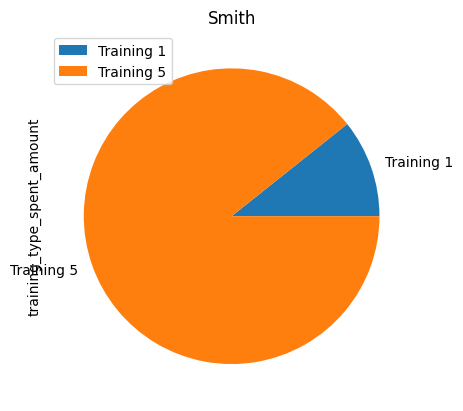

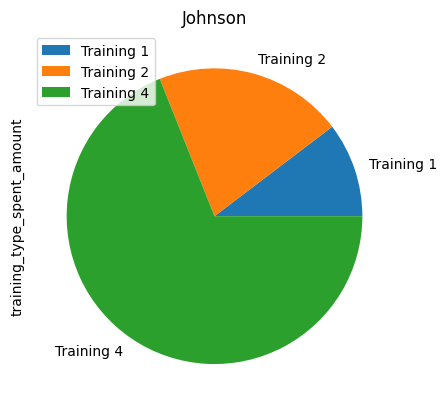

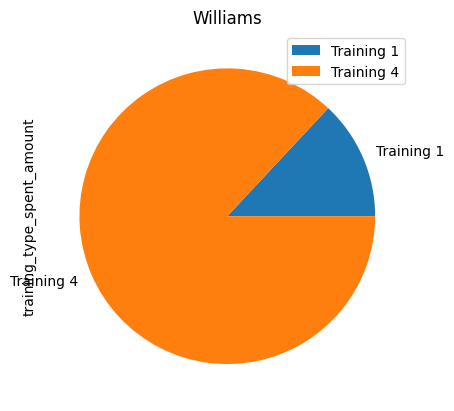

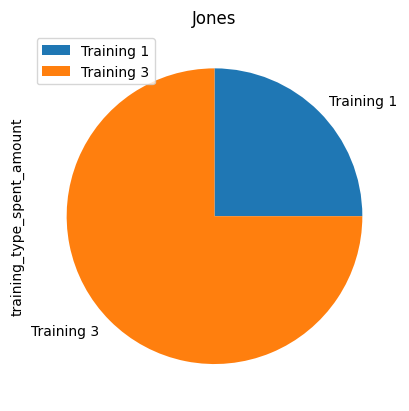

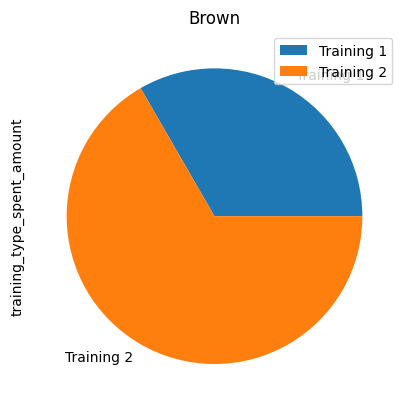

In [134]:
for visitor in visitors.itertuples():
    get_visitors_stats(visitor.visitor_surname).set_index('training_type_title').plot(kind='pie',
                                                                                      y='training_type_spent_amount',
                                                                                      title=visitor.visitor_surname)